In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import pandas as pd
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import applications
from keras.layers import Activation, Dropout, Flatten, Dense,GlobalAveragePooling2D, BatchNormalization
import visualkeras

In [3]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w1, w2, w3, **kwargs):
        super(WeightedAverageLayer, self).__init__(**kwargs)
        self.w1 = w1
        self.w2 = w2
        self.w3 = w3

    def call(self, inputs):
        return self.w1 * inputs[0] + self.w2 * inputs[1] +self.w3 * inputs[2]

In [4]:
labels_csv = pd.read_csv('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\\Codes\\Dog-Breed-Classification-using-Ensemble-Pretrained-Models-main\\labels.csv')
labels_csv['id'] = [str(fname) + '.jpg' for fname in labels_csv['id']]
data_train = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-224\\train')
data_test = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-224\\train')

data_train1 = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-299\\train')
data_test1 = pathlib.Path('E:\\dx\\Level 6\\Project\\Topic-Ensemble Model for the Classification of Dog Breed\\Dataset\\120dog breeds-299\\train')

In [5]:
batch_size = 16
img_size = 299

In [6]:
datagen = ImageDataGenerator(preprocessing_function = keras.applications.vgg16.preprocess_input, validation_split=0.2)
train_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train1,
                        subset="training",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size, img_size))

validation_generator = datagen.flow_from_dataframe(
                        dataframe = labels_csv,
                        directory = data_train1,
                        subset="validation",
                        x_col="id",
                        y_col="breed",
                        batch_size=batch_size,
                        shuffle=True,
                        class_mode="sparse",
                        color_mode="rgb",
                        target_size=(img_size, img_size))

Found 8178 validated image filenames belonging to 120 classes.
Found 2044 validated image filenames belonging to 120 classes.


In [7]:
vgg16 = applications.vgg16.VGG16(include_top=False, weights='imagenet',input_shape=(299,299,3))
resnet50 = keras.applications.ResNet50(include_top=False, weights='imagenet',input_shape=(299,299,3))
inceptionV3 = applications.inception_v3.InceptionV3(include_top=False, weights='imagenet',input_shape=(299,299,3))

for layer in vgg16 .layers:
    layer.trainable=False
for layer in resnet50.layers:
    layer.trainable=False
for layer in inceptionV3.layers:
    layer.trainable=False

model1 = Sequential()
model2 = Sequential()
model3 = Sequential()

model1.add(vgg16)
model1.add(BatchNormalization())
model1.add(GlobalAveragePooling2D())
model1.add(Dropout(0.5))
model1.add(Dense(1024, activation='leaky_relu'))
model1.add(Dropout(0.5))
model1.add(Dense(256, activation='leaky_relu'))
model1.add(Dropout(0.5))
model1.add(Dense(120, activation='softmax'))

model2.add(resnet50)
model2.add(BatchNormalization())
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.5))
model2.add(Dense(1024, activation='leaky_relu'))
model2.add(Dropout(0.5))
model2.add(Dense(120, activation='softmax'))

model3.add(inceptionV3)
model3.add(BatchNormalization())
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.5))
model3.add(Dense(1024, activation='leaky_relu'))
model3.add(Dropout(0.5))
model3.add(Dense(120, activation='softmax'))

optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001)
model1.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model2.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
model3.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])
# model1.save('model1.h5')
# model2.save('model2.h5')
# model3.save('model3.h5')

# history_vgg = model1.fit(train_generator, epochs=20, verbose = 1,
#                          validation_data=validation_generator)
#
# history_res = model2.fit(train_generator, epochs=20, verbose = 1,
#                        validation_data=validation_generator)
#
# history_inc = model3.fit(train_generator, epochs=20, verbose = 1,
#                         validation_data=validation_generator)


In [8]:
# models = [model1,model2,model3]
# model_input = tf.keras.Input(shape=(299, 299, 3))
# model_input1 = tf.keras.Input(shape=(299, 299, 3))
# model_outputs = [tf.cond(model==model3,lambda: model(model_input1),lambda: model(model_input)) for model in models]
# ensemble_output = tf.keras.layers.Average()(model_outputs)
# ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
# ensemble_model.compile(optimizer=optimizer,
#                        loss='sparse_categorical_crossentropy',
#                        metrics=['accuracy'])
# ensemble_model.summary()
models = [model1,model2,model3]
model_input = tf.keras.Input(shape=(299, 299, 3))
model_outputs = [model(model_input) for model in models]
ensemble_output = tf.keras.layers.Average()(model_outputs)
ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)
ensemble_model.compile(optimizer=optimizer,
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])
ensemble_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 120)          15535288    ['input_4[0][0]']                
                                                                                                  
 sequential_1 (Sequential)      (None, 120)          25817080    ['input_4[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 120)          24032152    ['input_4[0][0]']            

In [9]:
history_ens = ensemble_model.fit(train_generator, epochs=20, verbose = 1,
                                 validation_data=validation_generator)

Epoch 1/20
512/512 [==============================] - 2431s 5s/step - loss: 4.2758 - accuracy: 0.1442 - val_loss: 3.3579 - val_accuracy: 0.4618
Epoch 2/20
512/512 [==============================] - 2368s 5s/step - loss: 2.9562 - accuracy: 0.4830 - val_loss: 2.3228 - val_accuracy: 0.6561
Epoch 3/20
512/512 [==============================] - 2369s 5s/step - loss: 2.2675 - accuracy: 0.6261 - val_loss: 1.9200 - val_accuracy: 0.7226
Epoch 4/20
512/512 [==============================] - 2375s 5s/step - loss: 1.9424 - accuracy: 0.6917 - val_loss: 1.7328 - val_accuracy: 0.7446
Epoch 5/20
512/512 [==============================] - 2371s 5s/step - loss: 1.7684 - accuracy: 0.7130 - val_loss: 1.6190 - val_accuracy: 0.7466
Epoch 6/20
512/512 [==============================] - 2369s 5s/step - loss: 1.6421 - accuracy: 0.7261 - val_loss: 1.5424 - val_accuracy: 0.7593
Epoch 7/20
512/512 [==============================] - 2375s 5s/step - loss: 1.5427 - accuracy: 0.7512 - val_loss: 1.4859 - val_accuracy:

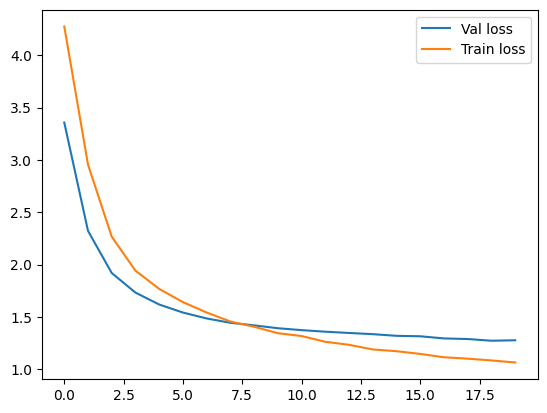

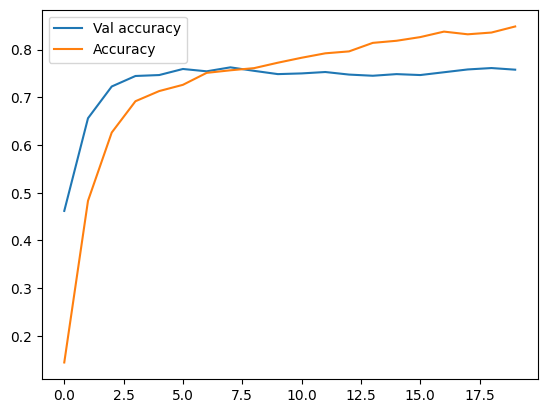

In [12]:
plt.figure()
plt.plot(history_ens .history["val_loss"], label = "Val loss")
plt.plot(history_ens .history["loss"], label = "Train loss")
plt.legend()
plt.show()
plt.figure()
plt.plot(history_ens .history["val_accuracy"], label = "Val accuracy")
plt.plot(history_ens .history["accuracy"], label = "Accuracy")
plt.legend()
plt.show()

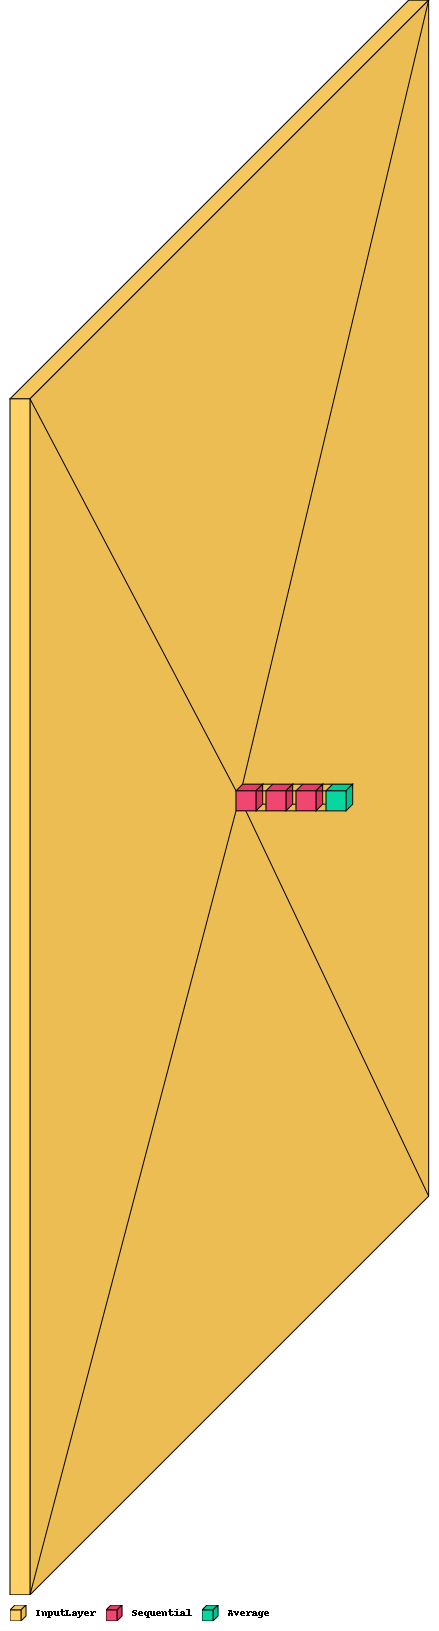

In [11]:
visualkeras.layered_view(ensemble_model,  legend=True)

<AxesSubplot:>

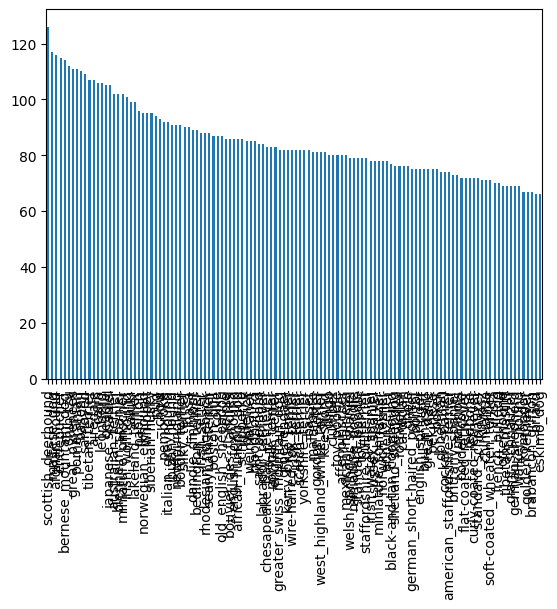

In [13]:
labels_csv['breed'].value_counts().plot(kind='bar')

# times=['1','2','3','4','5','6','7','8','9','10']
